In [1]:
# Plotly credentials stuff- run first time only
import plotly
plotly.tools.set_credentials_file(username='alankritjoshi', api_key='HeZ3RMcZarDeaMdAeIkU')
# plotly.tools.set_credentials_file(username='bdesnoy', api_key='VLNSHIH0dfFWjlXNEbiG')
# plotly.tools.set_credentials_file(username='junyi', api_key='sswCNaXW5ssm3JllQCRq')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np
import pandas as pd
import plotly.plotly as py
from re import match
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import statistics as stat

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

# Load the Dataset

In [4]:
data = pd.read_csv('behavioral_risk_factor_dataset.csv')

In [5]:
# Convert question to a category and rename categories for visibility
data["Question"] = data["Question"].astype("category")
data['Question'].cat.categories = ["% Overweight Adults",
                                   "% Obese Adults",
                                   "% Mod Aerobic", 
                                   "% Mod Aerobic & Strength", 
                                   "% Vigerous Aerobic", 
                                   "% Strength", 
                                   "% No Phys. Activity", 
                                   "% < 1 Fruit / Day", 
                                   "% < 1 Veg / Day"]

# Drop, unnecessary columns to make table human-readable
cols_to_drop = ['Datasource', 'Class', 'Topic', 'Data_Value_Unit', 
                'Data_Value_Type', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 
                'Data_Value_Footnote', 'Total', 'Age(years)', 'Education',
                'Gender', 'Income', 'Race/Ethnicity', 'ClassID', 
                'TopicID', 'QuestionID', 'DataValueTypeID', 'LocationID']
data.drop(cols_to_drop, axis = 1, inplace = True)

# remove 'Guam' ,'Puerto Rico', 'Virgin Islands'
data = data[data.LocationAbbr != 'VI']
data = data[data.LocationAbbr != 'PR']
data = data[data.LocationAbbr != 'GU']

In [6]:
list(data.columns)

['YearStart',
 'YearEnd',
 'LocationAbbr',
 'LocationDesc',
 'Question',
 'Data_Value',
 'Low_Confidence_Limit',
 'High_Confidence_Limit ',
 'Sample_Size',
 'GeoLocation',
 'StratificationCategory1',
 'Stratification1',
 'StratificationCategoryId1',
 'StratificationID1']

# Preview the Dataset

In [7]:
data.head(n=20)

,YearStart,YearEnd,LocationAbbr,LocationDesc,Question,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2011,2011,AL,Alabama,% Obese Adults,32.0,30.5,33.5,7304.0,"(32.84057112200048, -86.63186076199969)",Total,Total,OVR,OVERALL
1,2011,2011,AL,Alabama,% Obese Adults,32.3,29.9,34.7,2581.0,"(32.84057112200048, -86.63186076199969)",Gender,Male,GEN,MALE
2,2011,2011,AL,Alabama,% Obese Adults,31.8,30.0,33.6,4723.0,"(32.84057112200048, -86.63186076199969)",Gender,Female,GEN,FEMALE
3,2011,2011,AL,Alabama,% Obese Adults,33.6,29.9,37.6,1153.0,"(32.84057112200048, -86.63186076199969)",Education,Less than high school,EDU,EDUHS
4,2011,2011,AL,Alabama,% Obese Adults,32.8,30.2,35.6,2402.0,"(32.84057112200048, -86.63186076199969)",Education,High school graduate,EDU,EDUHSGRAD
5,2011,2011,AL,Alabama,% Obese Adults,33.8,31.0,36.8,1925.0,"(32.84057112200048, -86.63186076199969)",Education,Some college or technical school,EDU,EDUCOTEC
6,2011,2011,AL,Alabama,% Obese Adults,26.4,23.7,29.3,1812.0,"(32.84057112200048, -86.63186076199969)",Education,College graduate,EDU,EDUCOGRAD
7,2011,2011,AL,Alabama,% Obese Adults,16.3,12.6,20.9,356.0,"(32.84057112200048, -86.63186076199969)",Age (years),18 - 24,AGEYR,AGEYR1824
8,2011,2011,AL,Alabama,% Obese Adults,35.2,30.7,40.0,598.0,"(32.84057112200048, -86.63186076199969)",Age (years),25 - 34,AGEYR,AGEYR2534
9,2011,2011,AL,Alabama,% Obese Adults,35.5,31.6,39.6,865.0,"(32.84057112200048, -86.63186076199969)",Age (years),35 - 44,AGEYR,AGEYR3544


# Grab 2016 Data

In [8]:
data_2016 = data.query('YearStart == "2016"')

data_2016.head(n=5)

,YearStart,YearEnd,LocationAbbr,LocationDesc,Question,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
48772,2016,2016,US,National,% Overweight Adults,35.2,34.9,35.5,438479.0,NaN,Total,Total,OVR,OVERALL
48773,2016,2016,US,National,% Overweight Adults,41.0,40.6,41.5,198440.0,NaN,Gender,Male,GEN,MALE
48774,2016,2016,US,National,% Overweight Adults,29.3,28.9,29.7,240000.0,NaN,Gender,Female,GEN,FEMALE
48775,2016,2016,US,National,% Overweight Adults,34.7,33.6,35.7,32325.0,NaN,Education,Less than high school,EDU,EDUHS
48776,2016,2016,US,National,% Overweight Adults,34.2,33.7,34.8,123241.0,NaN,Education,High school graduate,EDU,EDUHSGRAD


# Visualizing Obesity by Location

In [9]:
def get_table_from_query(df, query):
    filtered_data = df.query(query)
    filtered_data = filtered_data.query('LocationAbbr != "US"')
    mean_over_years = filtered_data.groupby(['LocationAbbr', 'Question', 'StratificationCategoryId1', 'StratificationID1'])['Data_Value'].mean()
    filtered_data.drop_duplicates(['LocationAbbr', 'Question', 'StratificationCategoryId1', 'StratificationID1'], keep='last', inplace=True)
    filtered_data.set_index(['LocationAbbr', 'Question', 'StratificationCategoryId1', 'StratificationID1'], inplace=True)
    filtered_data['Data_Value'] = mean_over_years
    filtered_data.reset_index(inplace=True)
    return filtered_data

def get_total_incidence_table(df, question):
    return get_table_from_query(df, 'StratificationCategory1 == "Total" & Question == "%s"' % (question,))

In [10]:
obesity_data_by_state = get_total_incidence_table(data, "% Obese Adults")
obesity_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,LA,% Obese Adults,OVR,OVERALL,2016,2016,Louisiana,34.633333,33.4,37.7,4868.0,"(31.31266064400046, -92.44568007099969)",Total,Total
1,ME,% Obese Adults,OVR,OVERALL,2016,2016,Maine,28.850000,28.5,31.3,9554.0,"(45.254228894000505, -68.98503133599962)",Total,Total
2,MD,% Obese Adults,OVR,OVERALL,2016,2016,Maryland,28.766667,28.9,31.0,16701.0,"(39.29058096400047, -76.60926011099963)",Total,Total
3,MA,% Obese Adults,OVR,OVERALL,2016,2016,Massachusetts,23.400000,22.3,24.9,7480.0,"(42.27687047000046, -72.08269067499964)",Total,Total
4,MI,% Obese Adults,OVR,OVERALL,2016,2016,Michigan,31.383333,31.4,33.6,11130.0,"(44.6613195430005, -84.71439026999968)",Total,Total


In [11]:
# https://plot.ly/python/matplotlib-colorscales/
# use matplotlib style colorscales
magma_cmap = cm.get_cmap('magma')
viridis_cmap = cm.get_cmap('viridis')

viridis_rgb = []
magma_rgb = []
norm = colors.Normalize(vmin=0, vmax=255)

for i in range(0, 255):
       k = colors.colorConverter.to_rgb(magma_cmap(norm(i)))
       magma_rgb.append(k)

for i in range(0, 255):
       k = colors.colorConverter.to_rgb(viridis_cmap(norm(i)))
       viridis_rgb.append(k)
    
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

magma = matplotlib_to_plotly(magma_cmap, 255)
viridis = matplotlib_to_plotly(viridis_cmap, 255)

In [12]:
lat_long_regex = "\((-{0,1}[0-9]+.{0,1}[0-9]*),\s*(-{0,1}[0-9]+.{0,1}[0-9]*)\)"
def extract_lat_long(str):
    lat_long_match = match(lat_long_regex, str)
    return lat_long_match.groups()

def extract_lat(str):
    return float(extract_lat_long(str)[0])

def extract_long(str):
    return float(extract_lat_long(str)[1])

extract_lats = np.vectorize(extract_lat)
extract_longs = np.vectorize(extract_long)

In [13]:
# See Plotly Support: https://plot.ly/pandas/scatter-plots-on-maps/

def plot_basic(df, plot_title, bar_title, filename, colorscheme=magma):
    # Extract relevant data from dataframe
    locs = df["GeoLocation"]
    state_names = df["LocationDesc"] + ' (' +  df["Data_Value"].astype('str') + '%)'
    values = pd.to_numeric(df["Data_Value"])
    max_value = values.max()
    min_value = values.min()
    
    # Create a heat-map scale w/ colors for percentages
    state_marker = {'size': 8, 
                    'opacity': 0.8, 
                    'symbol': 'square', 
                    'line': {'width': 1, 
                             'color': 'rgba(102, 102, 102)'}, 
                    'cmin': min_value,
                    'cmax': max_value, 
                    'colorbar': {'title': bar_title}}
    state_bar = {
        'title': bar_title
    }
    plot_data = {'type': 'choropleth', 
                 'reversescale': True, 
                 'colorscale': colorscheme,
                 'locationmode': 'USA-states', 
                 'locations': df["LocationAbbr"],
                 'z': values,
                 'text': state_names, 
                 'mode': 'markers', 
                 'marker': state_marker,
                 'colorbar': state_bar}
        
    plot_layout = {'title': '<b>%s</b><br>(hover for state name and value)' % (plot_title,),
                   'colorbar': True, 
                   'width': 1400,
                   'height': 800,
                   'geo': {'scope': 'usa', 
                           'projection': {'type': 'albers usa'}, 
                           'showland': True, 
                           'landcolor': "rgb(250, 250, 250)",
                           'subunitcolor': "rgb(217, 217, 217)",
                           'countrycolor': "rgb(217, 217, 217)", 
                           'countrywidth': 0.5, 
                           'subunitwidth': 0.5}
                  }

    fig = dict(data=[plot_data], layout=plot_layout)
    return fig

# TODO: FIX THIS FUNCTION!
def plot_scatter(df, plot_title, bar_title, filename, colorscheme=magma):
    # Extract relevant data from dataframe
    locs = df["GeoLocation"]
    cluster_values = pd.to_numeric(df["Cluster"])
    max_value = cluster_values.max()
    min_value = cluster_values.min()
    
    scatter_marker = {'size': 8, 
                    'opacity': 0.8, 
                    'symbol': 'square', 
                    'line': {'width': 1, 
                             'color': 'rgba(102, 102, 102)'}, 
                    'cmin': min_value,
                    'cmax': max_value, 
                    'colorbar': {'title': bar_title}}
    scatter_bar = {
        'title': bar_title
    }
    
    plot_data = {'type': 'scattergeo', 
                 'reversescale': True, 
                 'colorscale': colorscheme,
                 'locationmode': 'USA-states', 
                 'lon': locs[0],
                 'lat': locs[1],
                 'text': cluster_values, 
                 'mode': 'markers', 
                 'marker': scatter_marker,
                 'colorbar': scatter_bar}
        
    plot_layout = {'title': '<b>%s</b><br>(hover for cluster index and value)' % (plot_title,),
                   'colorbar': True, 
                   'width': 1400,
                   'height': 800,
                   'geo': {'scope': 'usa', 
                           'projection': {'type': 'albers usa'}, 
                           'showland': True, 
                           'landcolor': "rgb(250, 250, 250)",
                           'subunitcolor': "rgb(217, 217, 217)",
                           'countrycolor': "rgb(217, 217, 217)", 
                           'countrywidth': 0.5, 
                           'subunitwidth': 0.5}
                  }

    fig = dict(data=[plot_data], layout=plot_layout)
    return fig
  
# direct to a plot.ly page with the plot
def show_on_web(fig):
    url = py.plot(fig, validate=False, filename=filename)

# show the plot
def show_on_notebook(fig):
    py.image.ishow(fig)

# save plot to <filename>.png
def save_plot(fig, filename):
    filename += '.png'
    py.image.save_as(fig, filename=filename)


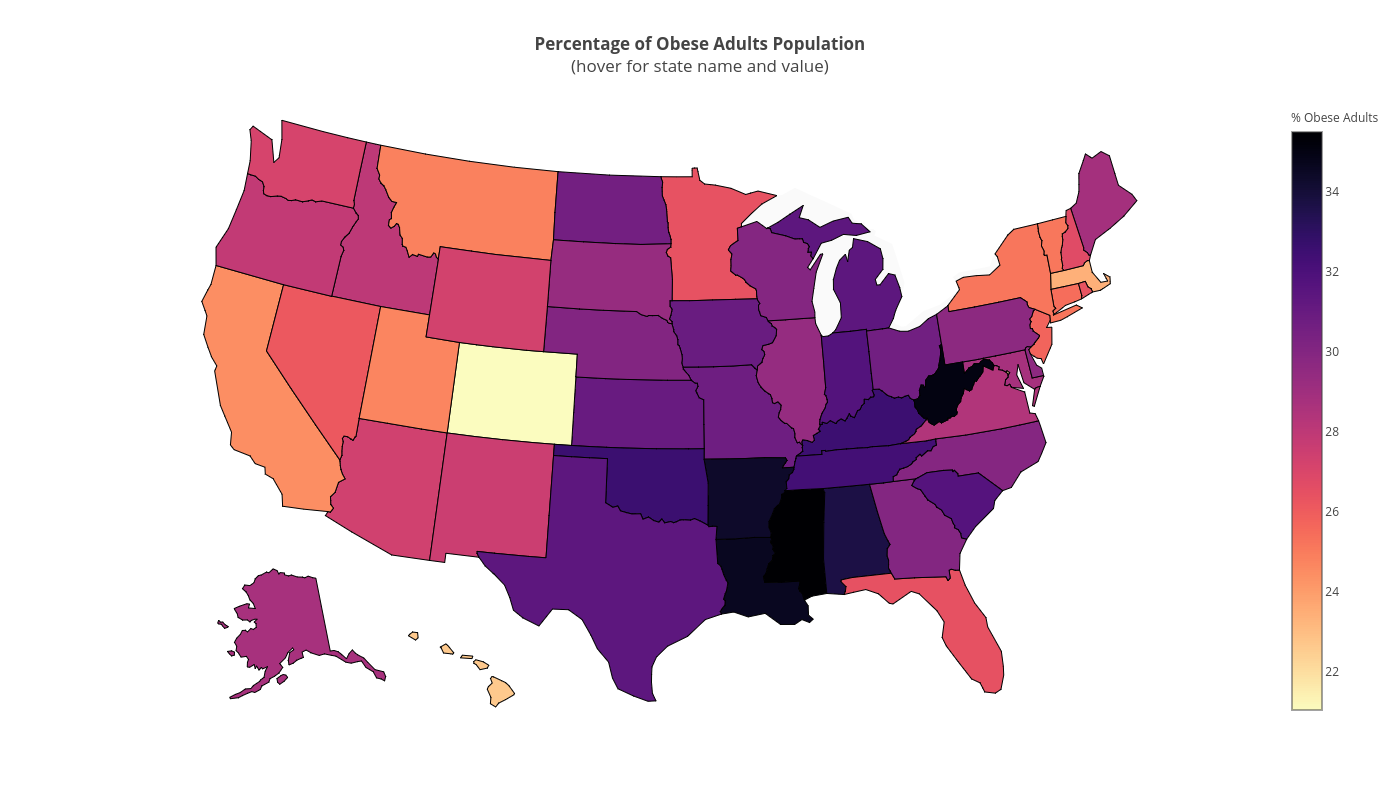

In [14]:
fig = plot_basic(obesity_data_by_state, 
          'Percentage of Obese Adults Population', 
          '% Obese Adults', 
          'd3-obesity')
show_on_notebook(fig)

# Visualizing Overweight Incidence (inc. Obesity) by Location

In [15]:
# Use grouping to get the actual number of overweight adults by state
overwieght_obesity_data = get_table_from_query(data, 'StratificationCategory1 == "Total" & (Question == "% Overweight Adults" | Question == "% Obese Adults")')
overweight_obesity_sum_by_state = overwieght_obesity_data.groupby(['LocationAbbr'])['Data_Value'].sum()

In [16]:
# Update the overweight adults table to use the actual number of overweight adults
overweight_data_by_state = get_total_incidence_table(data, "% Overweight Adults")
overweight_data_by_state.set_index('LocationAbbr', inplace=True)
overweight_data_by_state['LocationAbbr'] = overweight_data_by_state.index
overweight_data_by_state['Data_Value'] = overweight_obesity_sum_by_state
overweight_data_by_state.head(n=5)

,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1,LocationAbbr
LocationAbbr,,,,,,,,,,,,,,
AL,% Overweight Adults,OVR,OVERALL,2016,2016,Alabama,67.950000,32.3,35.4,6526.0,"(32.84057112200048, -86.63186076199969)",Total,Total,AL
AK,% Overweight Adults,OVR,OVERALL,2016,2016,Alaska,65.983333,32.4,38.2,2739.0,"(64.84507995700051, -147.72205903599973)",Total,Total,AK
AZ,% Overweight Adults,OVR,OVERALL,2016,2016,Arizona,63.216667,32.7,35.8,10033.0,"(34.865970280000454, -111.76381127699972)",Total,Total,AZ
AR,% Overweight Adults,OVR,OVERALL,2016,2016,Arkansas,68.616667,30.2,34.9,4859.0,"(34.74865012400045, -92.27449074299966)",Total,Total,AR
CA,% Overweight Adults,OVR,OVERALL,2016,2016,California,60.283333,34.8,37.2,10352.0,"(37.63864012300047, -120.99999953799971)",Total,Total,CA


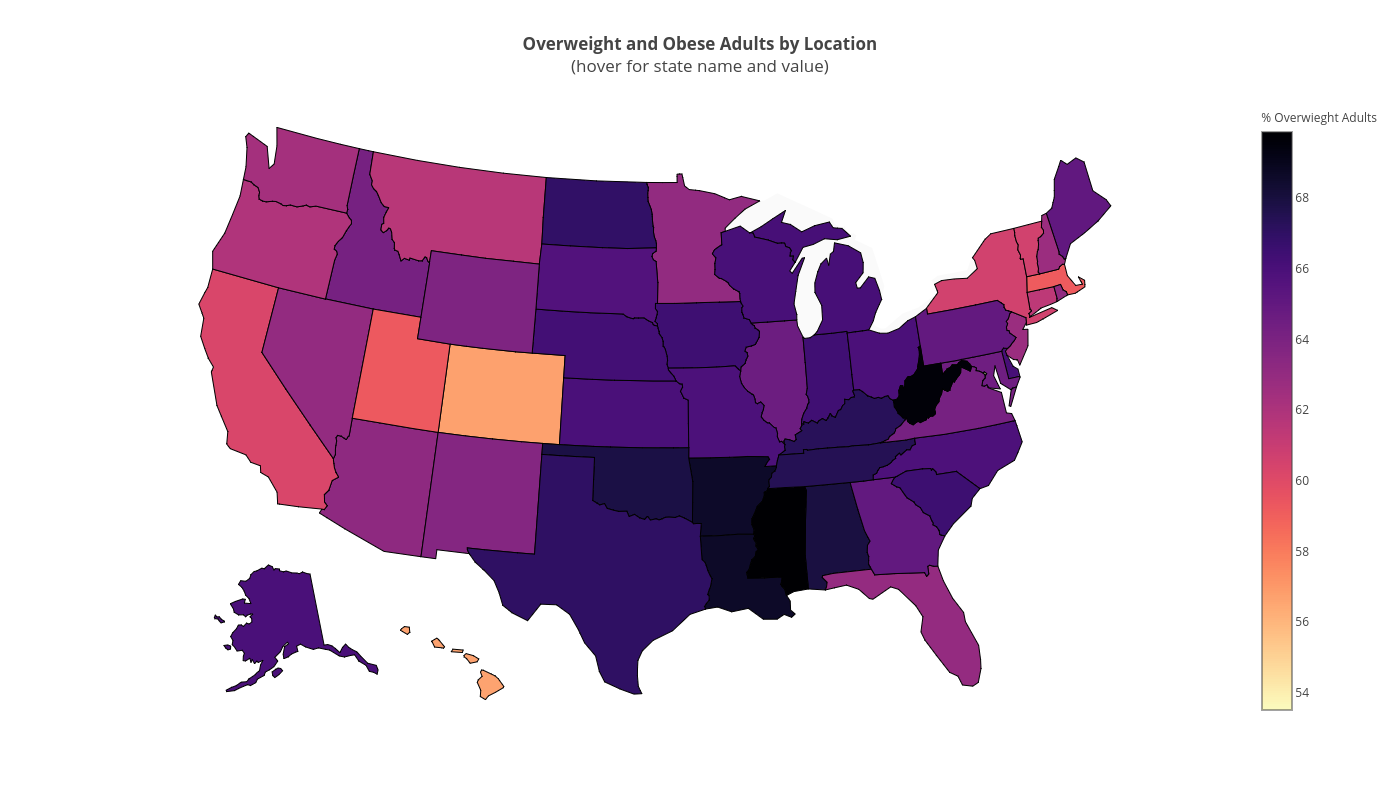

In [17]:
fig = plot_basic(overweight_data_by_state, 
           'Overweight and Obese Adults by Location', 
           '% Overwieght Adults', 
           'd3-overweight')
show_on_notebook(fig)
save_plot(fig, 'd3-overweight')

# Visualizing Inactivity by Location

In [18]:
inactivity_data_by_state = get_total_incidence_table(data, "% No Phys. Activity")
inactivity_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% No Phys. Activity,OVR,OVERALL,2016,2016,Alabama,30.033333,28.0,30.9,7013.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% No Phys. Activity,OVR,OVERALL,2016,2016,Alaska,20.516667,16.6,21.9,2910.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% No Phys. Activity,OVR,OVERALL,2016,2016,Arizona,23.483333,21.7,24.5,10921.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% No Phys. Activity,OVR,OVERALL,2016,2016,Arkansas,32.366667,30.3,34.8,5285.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% No Phys. Activity,OVR,OVERALL,2016,2016,California,20.316667,19.5,21.5,11386.0,"(37.63864012300047, -120.99999953799971)",Total,Total


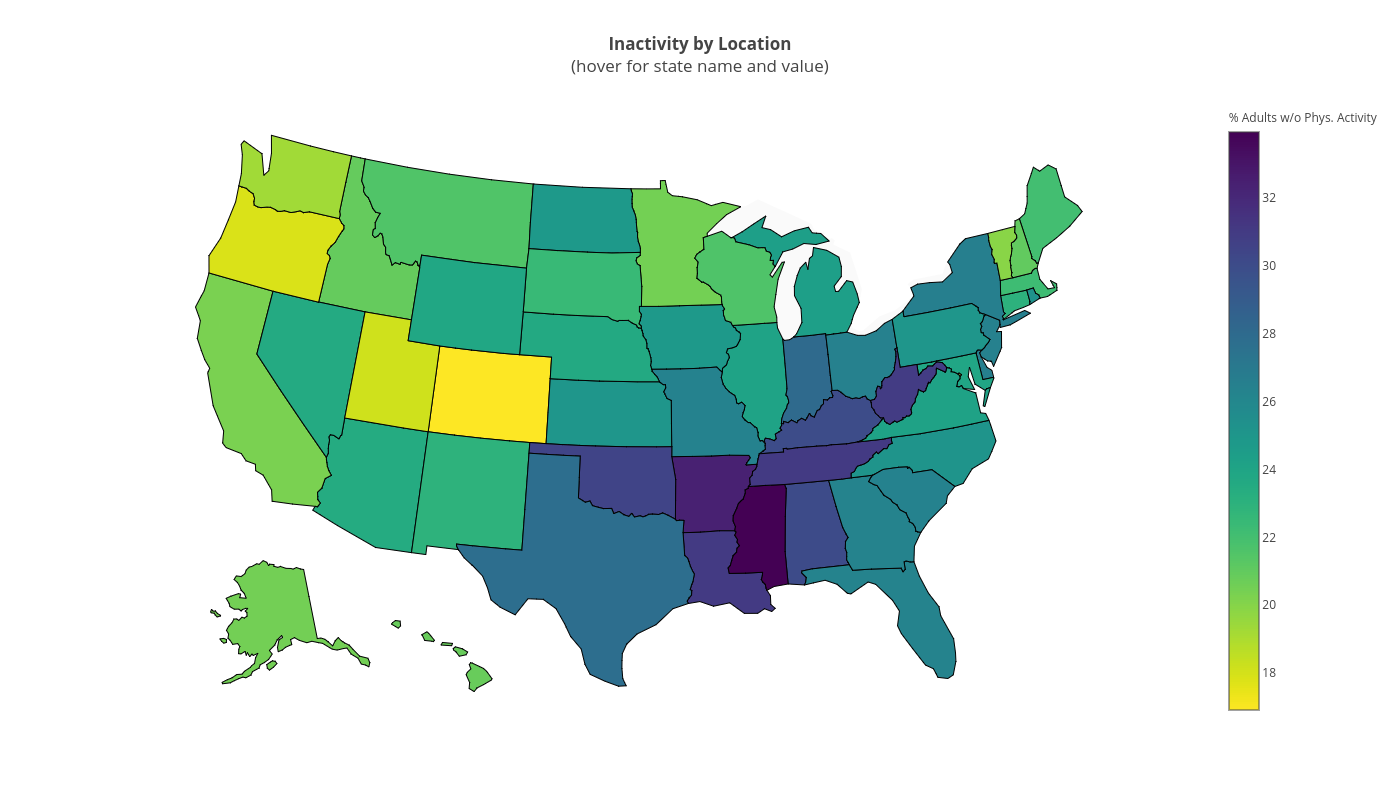

In [19]:
fig = plot_basic(inactivity_data_by_state, 
           'Inactivity by Location', 
           '% Adults w/o Phys. Activity', 
           'd3-inactive', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-inactive')

# Visualizing Vigerous Aerobic Activity by Location

In [20]:
vig_aerobic_by_state = get_total_incidence_table(data, "% Vigerous Aerobic")
inactivity_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% No Phys. Activity,OVR,OVERALL,2016,2016,Alabama,30.033333,28.0,30.9,7013.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% No Phys. Activity,OVR,OVERALL,2016,2016,Alaska,20.516667,16.6,21.9,2910.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% No Phys. Activity,OVR,OVERALL,2016,2016,Arizona,23.483333,21.7,24.5,10921.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% No Phys. Activity,OVR,OVERALL,2016,2016,Arkansas,32.366667,30.3,34.8,5285.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% No Phys. Activity,OVR,OVERALL,2016,2016,California,20.316667,19.5,21.5,11386.0,"(37.63864012300047, -120.99999953799971)",Total,Total


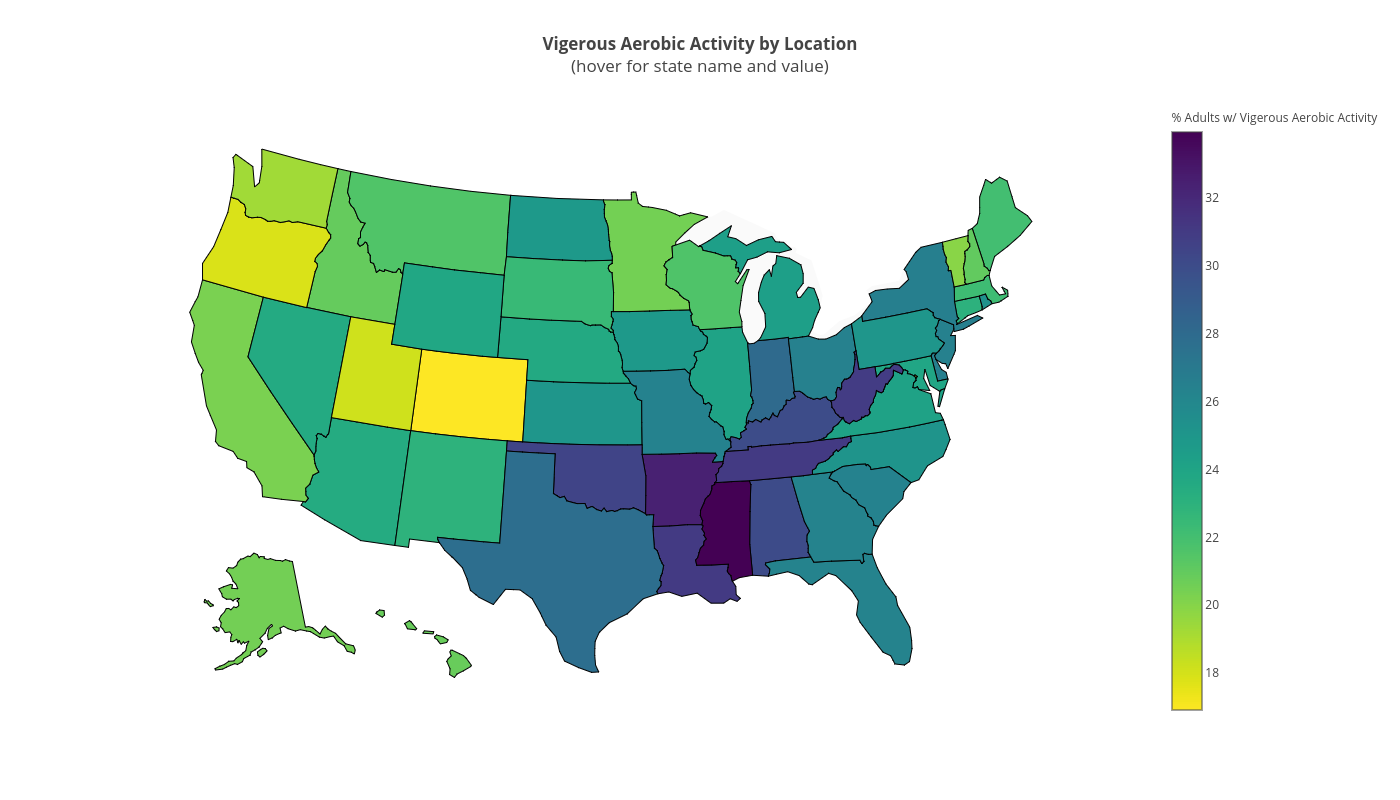

In [21]:
fig = plot_basic(inactivity_data_by_state, 
           'Vigerous Aerobic Activity by Location', 
           '% Adults w/ Vigerous Aerobic Activity', 
           'd3-vigerous', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-vigerous')

# Visualizing Vegetable Malnutrition by Location

In [22]:
veg_data_by_state = get_total_incidence_table(data, "% < 1 Veg / Day")
veg_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Alabama,25.966667,26.3,29.4,6938.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Alaska,19.266667,16.8,21.2,3322.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Arizona,21.633333,19.1,22.1,6905.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% < 1 Veg / Day,OVR,OVERALL,2015,2015,Arkansas,28.233333,25.8,30.5,4526.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% < 1 Veg / Day,OVR,OVERALL,2015,2015,California,17.466667,17.6,19.6,10846.0,"(37.63864012300047, -120.99999953799971)",Total,Total


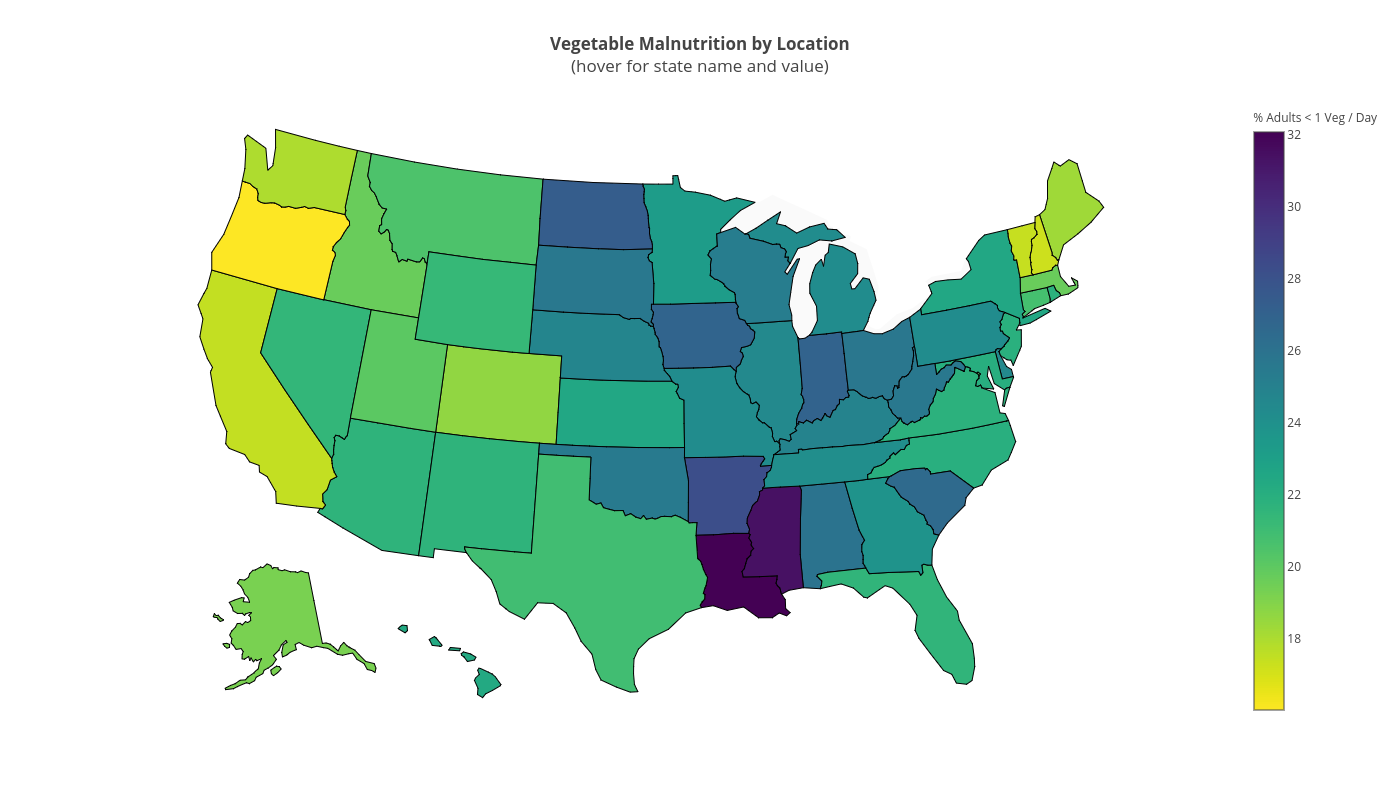

In [23]:
fig = plot_basic(veg_data_by_state, 
           'Vegetable Malnutrition by Location', 
           '% Adults < 1 Veg / Day', 
           'd3-veg', viridis)
show_on_notebook(fig)

# Visualizing Fruit Malnutrition by Location

In [24]:
fruit_data_by_state = get_total_incidence_table(data, "% < 1 Fruit / Day")
fruit_data_by_state.head(n=5)

,LocationAbbr,Question,StratificationCategoryId1,StratificationID1,YearStart,YearEnd,LocationDesc,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,GeoLocation,StratificationCategory1,Stratification1
0,AL,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Alabama,46.033333,46.7,49.9,7124.0,"(32.84057112200048, -86.63186076199969)",Total,Total
1,AK,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Alaska,39.800000,38.3,43.8,3364.0,"(64.84507995700051, -147.72205903599973)",Total,Total
2,AZ,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Arizona,39.066667,38.0,41.5,7068.0,"(34.865970280000454, -111.76381127699972)",Total,Total
3,AR,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,Arkansas,49.200000,47.1,52.1,4642.0,"(34.74865012400045, -92.27449074299966)",Total,Total
4,CA,% < 1 Fruit / Day,OVR,OVERALL,2015,2015,California,32.200000,34.7,37.0,11086.0,"(37.63864012300047, -120.99999953799971)",Total,Total


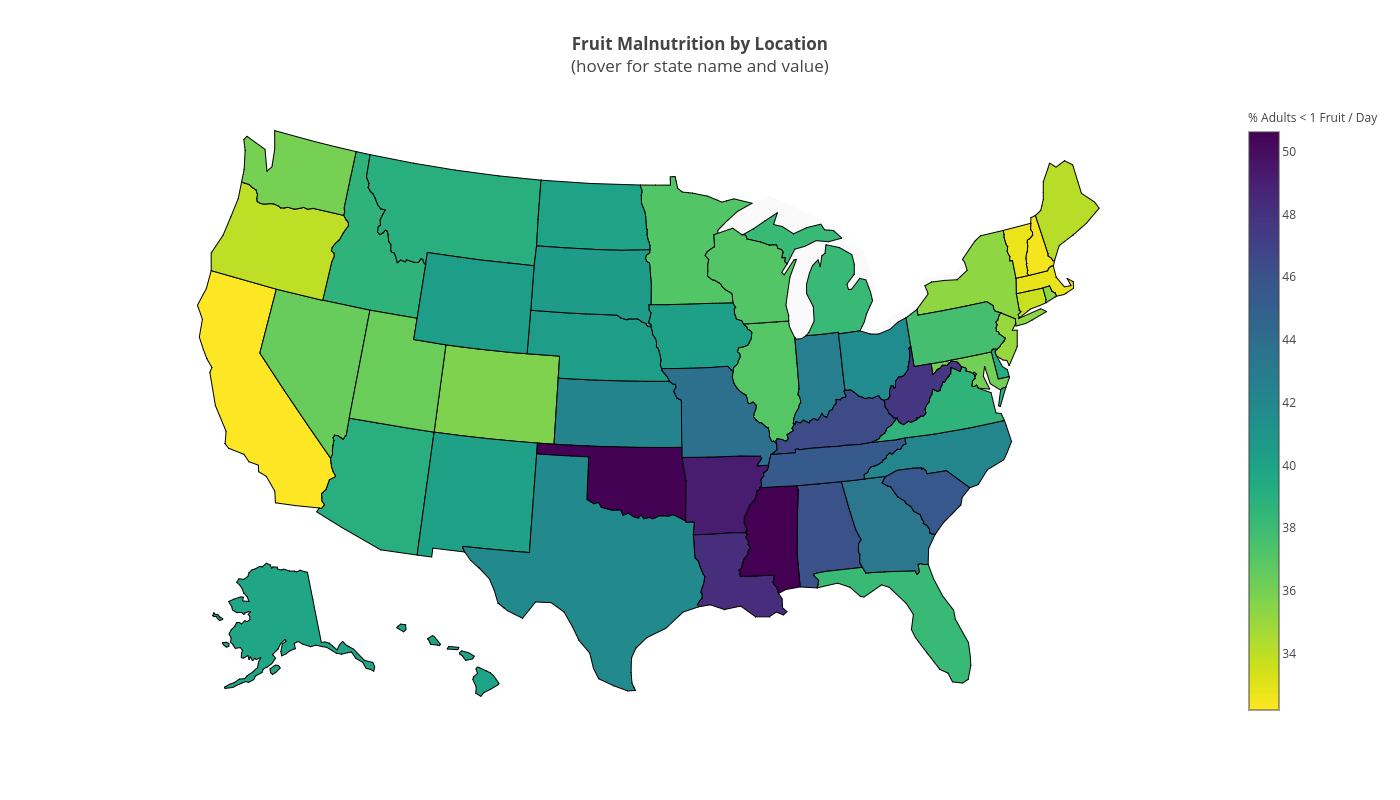

In [25]:
fig = plot_basic(fruit_data_by_state, 
           'Fruit Malnutrition by Location', 
           '% Adults < 1 Fruit / Day', 
           'd3-fruit', viridis)
show_on_notebook(fig)

# Plotting Correlation between Mean (over Years) Fruit Malnutrition and Obesity

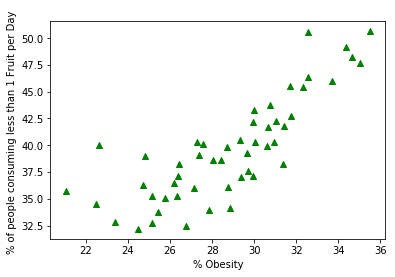

In [26]:
# X-axis: avg % obesity
# Y-axis: avg % of people consuming less than 1 fruit / day
plt.scatter(obesity_data_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           fruit_data_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           marker='^',
           color='g')
plt.xlabel('% Obesity')
plt.ylabel('% of people consuming less than 1 Fruit per Day ')
plt.show()

# Plotting Correlation between Mean (over Years) Vigerous Aerobic Activity and Obesity

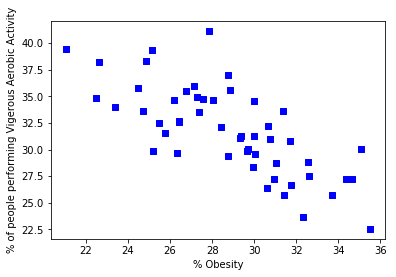

In [27]:
# X-axis: avg % obesity
# Y-axis: avg % of people performing vigerous aerobic activity
plt.scatter(obesity_data_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           vig_aerobic_by_state.sort_values(by='LocationAbbr', axis=0)['Data_Value'].tolist(),
           marker='s',
           color='b')
plt.xlabel('% Obesity')
plt.ylabel('% of people performing Vigerous Aerobic Activity')
plt.show()

# Read Risk Factor Data

In [28]:
# https://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment
edu_rates_data = pd.read_csv('educationrates.csv')
edu_rates_data.head(n=5)

,State,% High school graduate,% Bachelor's degree,% Advanced degree
0,Alabama,84.3,23.5,8.7
1,Alaska,92.1,28.0,10.1
2,Arizona,86.0,27.5,10.2
3,Arkansas,84.8,21.1,7.5
4,California,81.8,31.4,11.6


In [29]:
# https://en.wikipedia.org/wiki/Demography_of_the_United_States
demo_data = pd.read_csv('demography.csv')
demo_data.head(n=5)

,State or territory,% White,% Black or African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,% Two or more races
0,Alabama,68.8,26.4,0.5,1.2,0.1,1.3,1.7
1,Alaska,66.0,3.4,13.8,5.9,1.2,1.3,8.4
2,Arizona,78.4,4.2,4.4,3.0,0.2,6.5,3.2
3,Arkansas,78.0,15.5,0.6,1.4,0.2,2.1,2.1
4,California,61.8,5.9,0.7,13.7,0.4,12.9,4.5


In [30]:
# https://en.wikipedia.org/wiki/List_of_U.S._states_by_income
income_data = pd.read_csv('medianincome.csv')
income_data.head(n=5)

,State,$ Per capita income,$ Median household income,$ Median family income
0,Connecticut,39373,70048,88819
1,New Jersey,37288,69160,87951
2,Massachusetts,36593,71919,88419
3,Maryland,36338,73971,89678
4,New Hampshire,34691,66532,80581


In [31]:
# Join tables to get risk factor data
risk_factor_data = edu_rates_data.set_index('State').join(demo_data.set_index('State or territory')).join(income_data.set_index('State'))
risk_factor_data.head(n=5)

,% High school graduate,% Bachelor's degree,% Advanced degree,% White,% Black or African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,% Two or more races,$ Per capita income,$ Median household income,$ Median family income
State,,,,,,,,,,,,,
Alabama,84.3,23.5,8.7,68.8,26.4,0.5,1.2,0.1,1.3,1.7,23606,42830,53764
Alaska,92.1,28.0,10.1,66.0,3.4,13.8,5.9,1.2,1.3,8.4,33062,71583,82307
Arizona,86.0,27.5,10.2,78.4,4.2,4.4,3.0,0.2,6.5,3.2,25715,50068,59700
Arkansas,84.8,21.1,7.5,78.0,15.5,0.6,1.4,0.2,2.1,2.1,22883,41262,51528
California,81.8,31.4,11.6,61.8,5.9,0.7,13.7,0.4,12.9,4.5,30441,61933,71015


# Normalize Risk Factor Data

In [32]:
risk_factor_data_norm = pd.DataFrame(MinMaxScaler().fit_transform(risk_factor_data))
risk_factor_data_norm.index = risk_factor_data.index
risk_factor_data_norm.columns = risk_factor_data.columns
risk_factor_data_norm.head(n=5)

,% High school graduate,% Bachelor's degree,% Advanced degree,% White,% Black or African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,% Two or more races,$ Per capita income,$ Median household income,$ Median family income
State,,,,,,,,,,,,,
Alabama,0.235849,0.201878,0.126214,0.623563,0.701897,0.022059,0.013514,0.010101,0.086614,0.022222,0.140154,0.091861,0.090785
Alaska,0.971698,0.413146,0.262136,0.583333,0.078591,1.000000,0.140541,0.121212,0.086614,0.320000,0.655832,0.930361,0.813392
Arizona,0.396226,0.389671,0.271845,0.761494,0.100271,0.308824,0.062162,0.020202,0.496063,0.088889,0.255167,0.302937,0.241063
Arkansas,0.283019,0.089202,0.009709,0.755747,0.406504,0.029412,0.018919,0.020202,0.149606,0.040000,0.100725,0.046135,0.034177
California,0.000000,0.572770,0.407767,0.522989,0.146341,0.036765,0.351351,0.040404,1.000000,0.146667,0.512897,0.648946,0.527519


# Perform Risk Factor Clustering via $K$-means

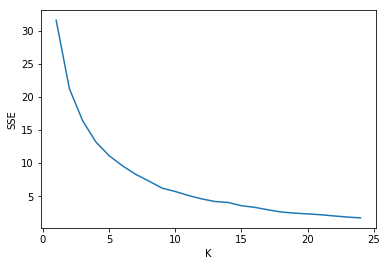

In [33]:
# Find ideal number of clusters
sse = []
k = []

for i in range(1, 25):
    kmeans = KMeans(n_clusters=i).fit(risk_factor_data_norm)
    k.append(i)
    sse.append(kmeans.inertia_)

plt.plot(k, sse)
plt.ylabel('SSE')
plt.xlabel('K')
plt.show()

In [34]:
# Perform K-means to find clusters
risk_factor_kmeans = KMeans(n_clusters=5).fit(risk_factor_data_norm)
risk_factor_data_w_clusters = risk_factor_data.copy()
risk_factor_data_w_clusters['Cluster'] = risk_factor_kmeans.labels_
risk_factor_data_w_clusters.head(n=5)

,% High school graduate,% Bachelor's degree,% Advanced degree,% White,% Black or African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,% Two or more races,$ Per capita income,$ Median household income,$ Median family income,Cluster
State,,,,,,,,,,,,,,
Alabama,84.3,23.5,8.7,68.8,26.4,0.5,1.2,0.1,1.3,1.7,23606,42830,53764,3
Alaska,92.1,28.0,10.1,66.0,3.4,13.8,5.9,1.2,1.3,8.4,33062,71583,82307,1
Arizona,86.0,27.5,10.2,78.4,4.2,4.4,3.0,0.2,6.5,3.2,25715,50068,59700,2
Arkansas,84.8,21.1,7.5,78.0,15.5,0.6,1.4,0.2,2.1,2.1,22883,41262,51528,3
California,81.8,31.4,11.6,61.8,5.9,0.7,13.7,0.4,12.9,4.5,30441,61933,71015,2


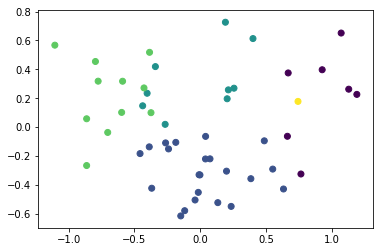

In [35]:
# Perform PCA to make 2D risk factor plot
pca = PCA(n_components=2).fit(risk_factor_data_norm)
pca_2d = pca.transform(risk_factor_data_norm).transpose()
pca_2d

plt.scatter(pca_2d[0], pca_2d[1], c=risk_factor_kmeans.labels_, marker='o')
plt.show()

In [36]:
# FIND STATES, GEOLOCATIONS AND ABBREVS (EXCEPT DC)
state_values = inactivity_data_by_state[inactivity_data_by_state.LocationAbbr != 'DC'][['GeoLocation', 'LocationDesc', 'LocationAbbr']].copy()
state_values.head(n=5)

,GeoLocation,LocationDesc,LocationAbbr
0,"(32.84057112200048, -86.63186076199969)",Alabama,AL
1,"(64.84507995700051, -147.72205903599973)",Alaska,AK
2,"(34.865970280000454, -111.76381127699972)",Arizona,AZ
3,"(34.74865012400045, -92.27449074299966)",Arkansas,AR
4,"(37.63864012300047, -120.99999953799971)",California,CA


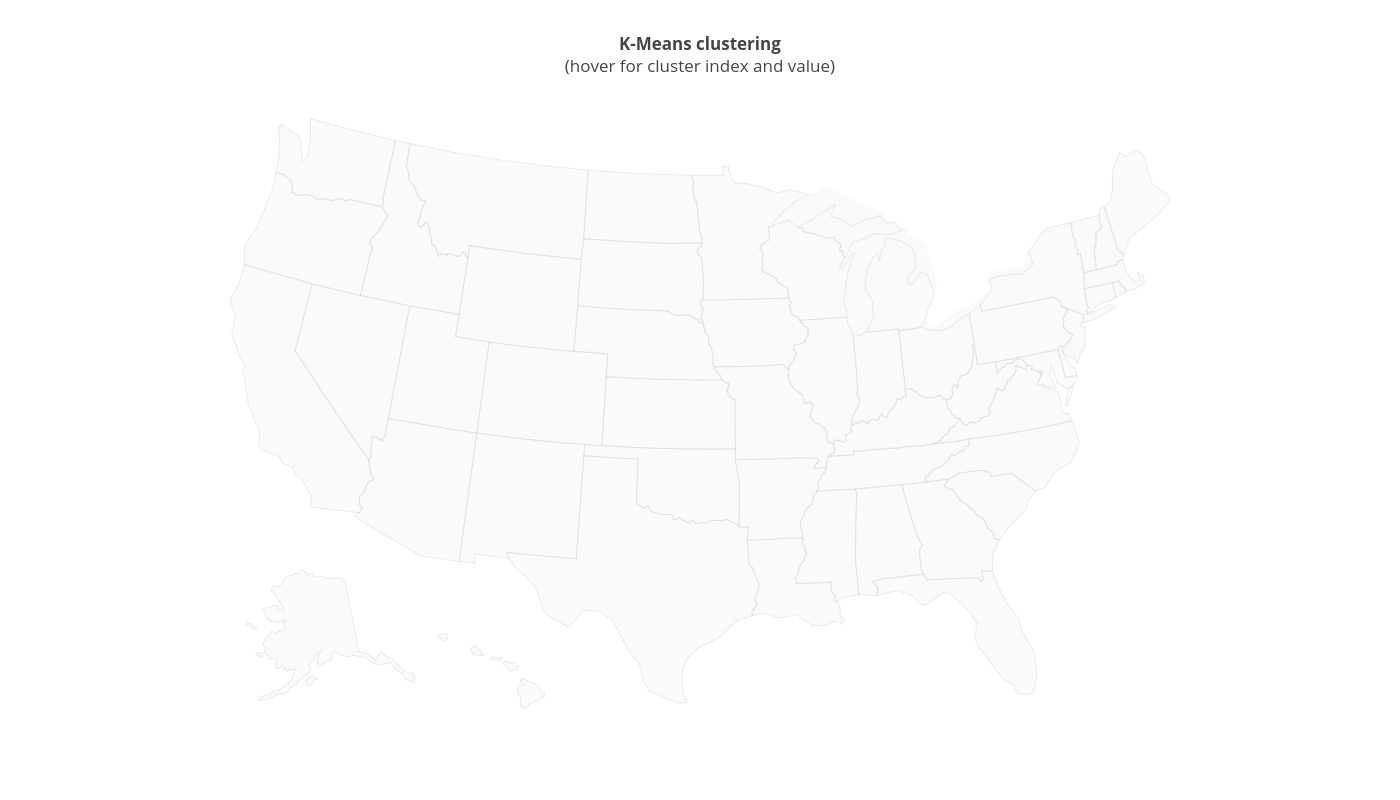

In [37]:
# TODO: Plot these on state map using plot_scatter FIX THIS!
kmeans_risk_factor_plot = pd.merge(risk_factor_data_w_clusters, state_values, left_index = True, right_on = ['LocationDesc'], how='outer')
fig = plot_scatter(kmeans_risk_factor_plot, 
           'K-Means clustering', 
           'Clusters', 
           'd3-inactive', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-inactive')

# Perform Risk Factor Clustering via DBSCAN

## Use KNN to tune DBSCAN parameters¶

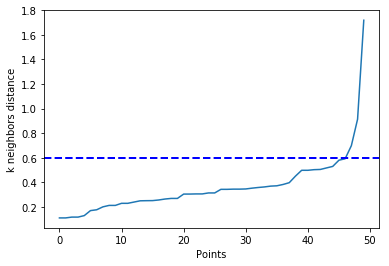

In [284]:
k = 2

nbrs = NearestNeighbors(n_neighbors=k).fit(risk_factor_data_norm)
distances, _ = nbrs.kneighbors(risk_factor_data_norm)
distances = np.sort(distances[:,-1])
plt.plot(range(len(distances)), distances)
plt.axhline(0.3, color='b', linestyle='dashed', linewidth=2)
plt.ylabel('k neighbors distance')
plt.xlabel('Points')
plt.show()

### Use DBSCAN with the parameters

In [296]:
# Perform DBSCAN to find clusters
risk_factor_db = DBSCAN(eps=0.3, min_samples=2).fit(risk_factor_data_norm)
risk_factor_data_w_DB_clusters = risk_factor_data.copy()
risk_factor_data_w_DB_clusters['Cluster'] = risk_factor_db.labels_
risk_factor_data_w_DB_clusters.head(n=5)

,% High school graduate,% Bachelor's degree,% Advanced degree,% White,% Black or African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,% Two or more races,$ Per capita income,$ Median household income,$ Median family income,Cluster
State,,,,,,,,,,,,,,
Alabama,84.3,23.5,8.7,68.8,26.4,0.5,1.2,0.1,1.3,1.7,23606,42830,53764,0
Alaska,92.1,28.0,10.1,66.0,3.4,13.8,5.9,1.2,1.3,8.4,33062,71583,82307,-1
Arizona,86.0,27.5,10.2,78.4,4.2,4.4,3.0,0.2,6.5,3.2,25715,50068,59700,-1
Arkansas,84.8,21.1,7.5,78.0,15.5,0.6,1.4,0.2,2.1,2.1,22883,41262,51528,-1
California,81.8,31.4,11.6,61.8,5.9,0.7,13.7,0.4,12.9,4.5,30441,61933,71015,-1


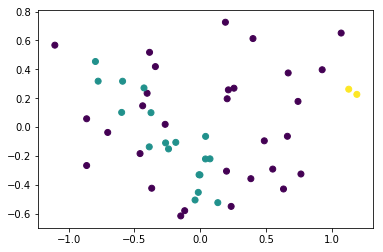

In [297]:
# Perform PCA to make 2D risk factor plot
pca = PCA(n_components=2).fit(risk_factor_data_norm)
pca_2d = pca.transform(risk_factor_data_norm).transpose()
pca_2d

plt.scatter(pca_2d[0], pca_2d[1], c=risk_factor_db.labels_, marker='o')
plt.show()

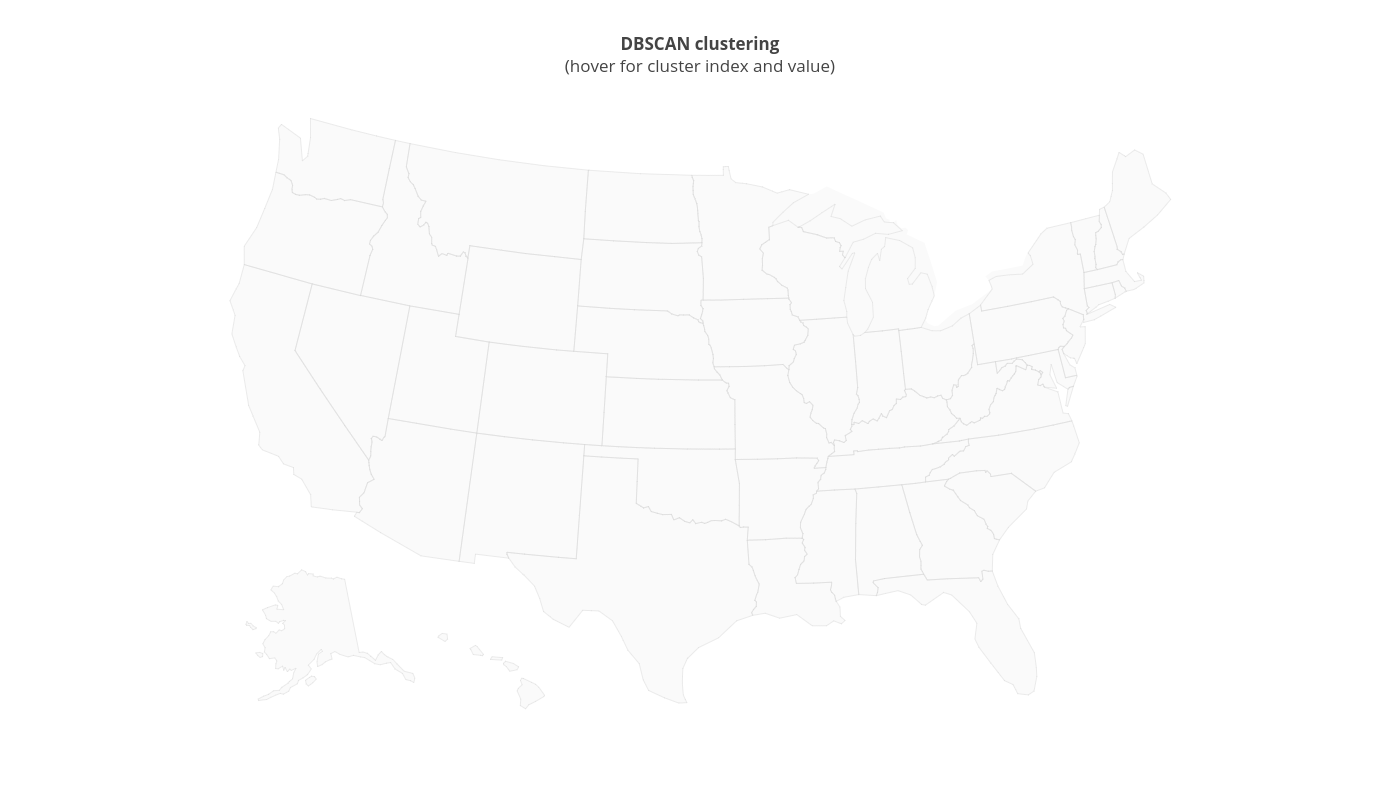

In [214]:
# TODO: Plot these on state map using plot_scatter FIX THIS!
dbscan_risk_factor_plot = pd.merge(risk_factor_data_w_DB_clusters, state_values, left_index = True, right_on = ['LocationDesc'], how='outer')
fig = plot_scatter(dbscan_risk_factor_plot, 
           'DBSCAN clustering', 
           'Clusters', 
           'd3-inactive', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-inactive')

# Aggregate Outcome Data into a Single Table

In [42]:
# Extract obesity values
obesity_values = pd.DataFrame(obesity_data_by_state[obesity_data_by_state.LocationAbbr != 'DC'].set_index('LocationDesc')['Data_Value'])
obesity_values.columns = ['% Obesity']
obesity_values.head(n=5)

,% Obesity
LocationDesc,
Louisiana,34.633333
Maine,28.850000
Maryland,28.766667
Massachusetts,23.400000
Michigan,31.383333


In [43]:
# Extract overweight values
oweight_values = pd.DataFrame(overweight_data_by_state[overweight_data_by_state.LocationAbbr != 'DC'].set_index('LocationDesc')['Data_Value'])
oweight_values.columns = ['% Overweight']
oweight_values.head(n=5)

,% Overweight
LocationDesc,
Alabama,67.950000
Alaska,65.983333
Arizona,63.216667
Arkansas,68.616667
California,60.283333


In [44]:
# Extract inactivity values
inact_values = pd.DataFrame(inactivity_data_by_state[inactivity_data_by_state.LocationAbbr != 'DC'].set_index('LocationDesc')['Data_Value'])
inact_values.columns = ['% No Physical Activity']
inact_values.head(n=5)

,% No Physical Activity
LocationDesc,
Alabama,30.033333
Alaska,20.516667
Arizona,23.483333
Arkansas,32.366667
California,20.316667


In [45]:
# Extract vigerous aerobic activity values
vigaer_values = pd.DataFrame(vig_aerobic_by_state[vig_aerobic_by_state.LocationAbbr != 'DC'].set_index('LocationDesc')['Data_Value'])
vigaer_values.columns = ['% Vigerous Aerobic']
vigaer_values.head(n=5)

,% Vigerous Aerobic
LocationDesc,
Alabama,25.766667
Alaska,37.033333
Arizona,33.500000
Arkansas,27.233333
California,35.800000


In [46]:
# Extract vegetable malnutriton values
veg_values = pd.DataFrame(veg_data_by_state[veg_data_by_state.LocationAbbr != 'DC'].set_index('LocationDesc')['Data_Value'])
veg_values.columns = ['% < 1 Veg / Day']
veg_values.head(n=5)

,% < 1 Veg / Day
LocationDesc,
Alabama,25.966667
Alaska,19.266667
Arizona,21.633333
Arkansas,28.233333
California,17.466667


In [47]:
# Extract fruit values
fruit_values = pd.DataFrame(fruit_data_by_state[fruit_data_by_state.LocationAbbr != 'DC'].set_index('LocationDesc')['Data_Value'])
fruit_values.columns = ['% < 1 Fruit / Day']
fruit_values.head(n=5)

,% < 1 Fruit / Day
LocationDesc,
Alabama,46.033333
Alaska,39.800000
Arizona,39.066667
Arkansas,49.200000
California,32.200000


In [48]:
# Join the individual tables together
outcome_data = obesity_values.join(oweight_values.join(inact_values.join(vigaer_values.join(veg_values.join(fruit_values)))))
outcome_data.head(n=5)

,% Obesity,% Overweight,% No Physical Activity,% Vigerous Aerobic,% < 1 Veg / Day,% < 1 Fruit / Day
LocationDesc,,,,,,
Louisiana,34.633333,68.650000,31.066667,27.233333,32.066667,48.200000
Maine,28.850000,65.033333,22.050000,35.566667,18.300000,34.133333
Maryland,28.766667,64.483333,23.866667,29.400000,22.033333,36.100000
Massachusetts,23.400000,59.166667,22.233333,33.966667,19.700000,32.800000
Michigan,31.383333,66.133333,24.366667,33.633333,24.233333,38.233333


# Normalize Outcome Data
(Although this is slightly less necessary since they are all percents, we will do anyway for consistency)

In [49]:
outcome_data_norm = pd.DataFrame(MinMaxScaler().fit_transform(outcome_data))
outcome_data_norm.index = outcome_data.index
outcome_data_norm.columns = outcome_data.columns
outcome_data_norm.head(n=5)

,% Obesity,% Overweight,% No Physical Activity,% Vigerous Aerobic,% < 1 Veg / Day,% < 1 Fruit / Day
LocationDesc,,,,,,
Louisiana,0.940023,0.908060,0.831538,0.251799,1.000000,0.867993
Maine,0.539792,0.634761,0.301665,0.701439,0.141372,0.104882
Maryland,0.534025,0.593199,0.408423,0.368705,0.374220,0.211573
Massachusetts,0.162630,0.191436,0.312439,0.615108,0.228690,0.032550
Michigan,0.715110,0.717884,0.437806,0.597122,0.511435,0.327306


# Perform Outcome Clustering via $K$-means

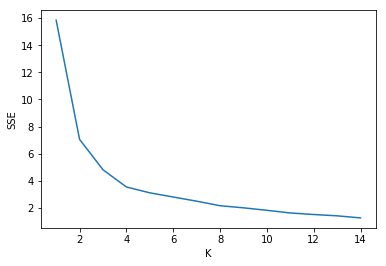

In [50]:
# Find ideal number of clusters
sse = []
k = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters=i).fit(outcome_data_norm)
    k.append(i)
    sse.append(kmeans.inertia_)

plt.plot(k, sse)
plt.ylabel('SSE')
plt.xlabel('K')
plt.show()

In [51]:
# Perform K-means to find clusters
outcome_kmeans = KMeans(n_clusters=3).fit(outcome_data_norm)
outcome_data_w_clusters = outcome_data.copy()
outcome_data_w_clusters['Cluster'] = outcome_kmeans.labels_
outcome_data_w_clusters.head(n=5)

,% Obesity,% Overweight,% No Physical Activity,% Vigerous Aerobic,% < 1 Veg / Day,% < 1 Fruit / Day,Cluster
LocationDesc,,,,,,,
Louisiana,34.633333,68.650000,31.066667,27.233333,32.066667,48.200000,0
Maine,28.850000,65.033333,22.050000,35.566667,18.300000,34.133333,1
Maryland,28.766667,64.483333,23.866667,29.400000,22.033333,36.100000,2
Massachusetts,23.400000,59.166667,22.233333,33.966667,19.700000,32.800000,1
Michigan,31.383333,66.133333,24.366667,33.633333,24.233333,38.233333,2


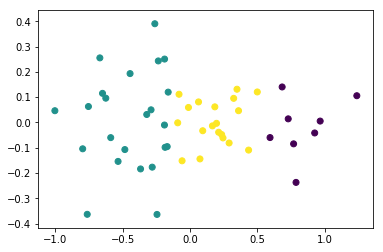

In [52]:
# Perform PCA to make 2D risk factor plot
pca = PCA(n_components=2).fit(outcome_data_norm)
pca_2d = pca.transform(outcome_data_norm).transpose()
pca_2d

plt.scatter(pca_2d[0], pca_2d[1], c=outcome_kmeans.labels_, marker='o')
plt.show()

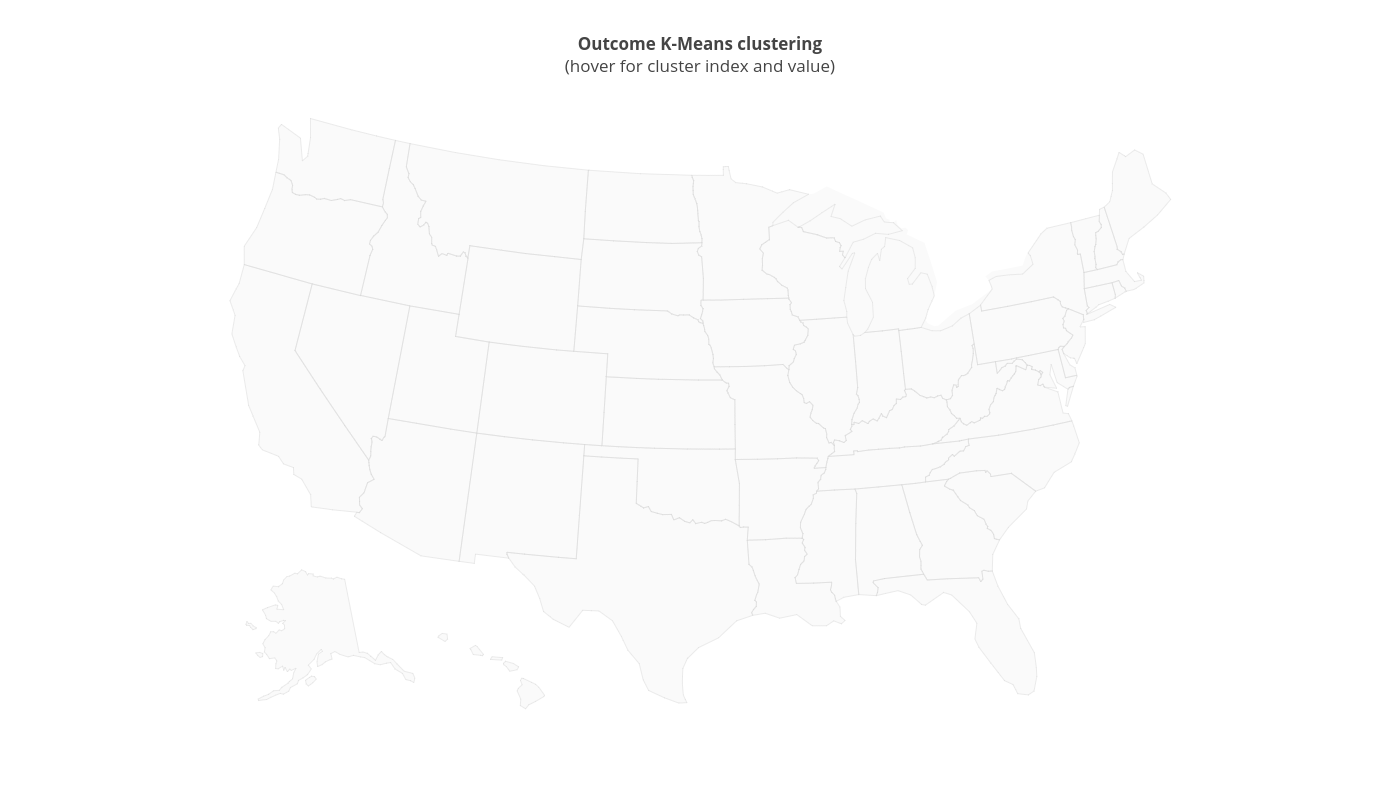

In [53]:
# TODO: Plot these on state map using plot_scatter FIX THIS!
outcome_kmeans_risk_factor_plot = pd.merge(outcome_data_w_clusters, state_values, left_index = True, right_on = ['LocationDesc'], how='outer')
fig = plot_scatter(outcome_kmeans_risk_factor_plot, 
           'Outcome K-Means clustering', 
           'Clusters', 
           'd3-inactive', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-inactive')

# Perform Risk Factor Clustering via DBSCAN

## Use KNN to tune DBSCAN parameters

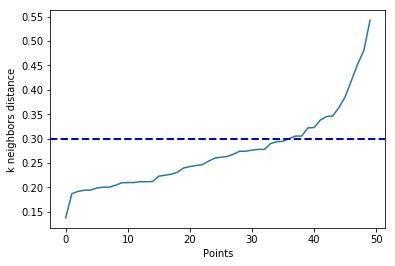

In [193]:
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(outcome_data_norm)
distances, _ = nbrs.kneighbors(outcome_data_norm)
distances = np.sort(distances[:,-1])
plt.plot(range(len(distances)), distances)
plt.axhline(0.3, color='b', linestyle='dashed', linewidth=2)
plt.ylabel('k neighbors distance')
plt.xlabel('Points')
plt.show()

## Use DBSCAN with the parameters

In [195]:
# Perform DBSCAN to find clusters
outcome_db = DBSCAN(eps=0.3, min_samples=4).fit(outcome_data_norm)
outcome_data_w_DB_clusters = outcome_data.copy()
outcome_data_w_DB_clusters['Cluster'] = outcome_db.labels_
outcome_data_w_DB_clusters.head(n=5)

,% Obesity,% Overweight,% No Physical Activity,% Vigerous Aerobic,% < 1 Veg / Day,% < 1 Fruit / Day,Cluster
LocationDesc,,,,,,,
Louisiana,34.633333,68.650000,31.066667,27.233333,32.066667,48.200000,0
Maine,28.850000,65.033333,22.050000,35.566667,18.300000,34.133333,0
Maryland,28.766667,64.483333,23.866667,29.400000,22.033333,36.100000,0
Massachusetts,23.400000,59.166667,22.233333,33.966667,19.700000,32.800000,0
Michigan,31.383333,66.133333,24.366667,33.633333,24.233333,38.233333,0


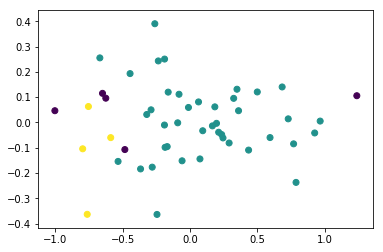

In [196]:
### Perform PCA to make 2D risk factor plot
pca = PCA(n_components=2).fit(outcome_data_norm)
pca_2d = pca.transform(outcome_data_norm).transpose()
pca_2d

plt.scatter(pca_2d[0], pca_2d[1], c=outcome_db.labels_, marker='o')
plt.show()

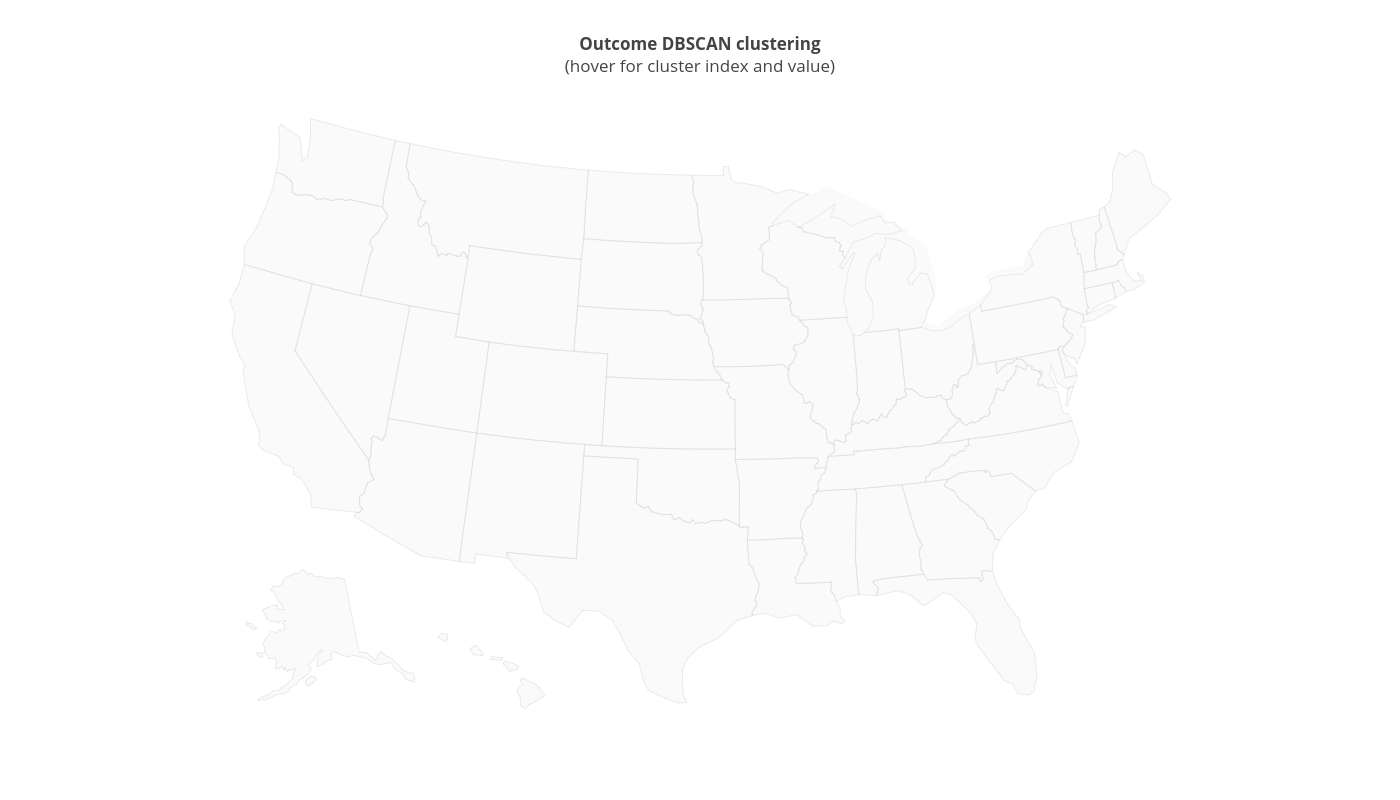

In [197]:
# TODO: Plot these on state map using plot_scatter FIX THIS!
outcome_dbscan_risk_factor_plot = pd.merge(outcome_data_w_DB_clusters, state_values, left_index = True, right_on = ['LocationDesc'], how='outer')
fig = plot_scatter(outcome_dbscan_risk_factor_plot, 
           'Outcome DBSCAN clustering', 
           'Clusters', 
           'd3-inactive', viridis)
                
show_on_notebook(fig)
save_plot(fig, 'd3-inactive')